In [1]:
from utils import get_scanpy_lfcs, get_seurat_lfcs, get_ZILN_lfcs, transform
import numpy as np
import matplotlib.pyplot as plt

### In the next (jupyter) cell we show that when the gene count distributions are the same for all genes for all cells/samples in a group/condition, then the normalization pre-processing step makes the means of the control and treatment distributions indistinguishable. This is true even if there is a big LFC between the two groups. Further down you'll find a proof that this holds in theory, too.

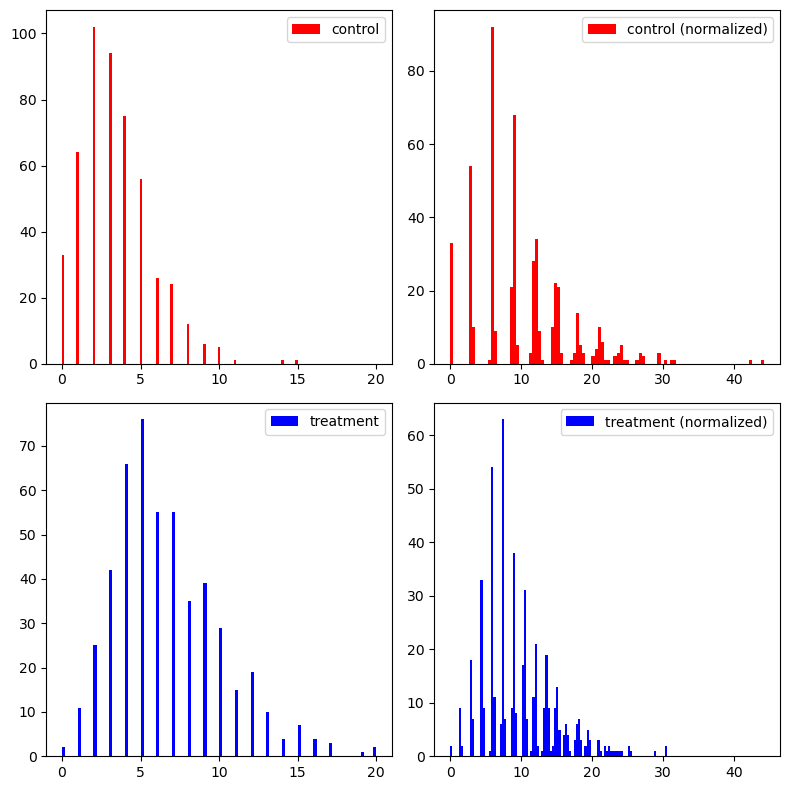

In [19]:
r_x = 5
r_y = 10
p = 0.6
true_lfc = np.log2(r_y / r_x)

X = np.random.negative_binomial(r_x, p, size=(500, 1000))
Y = np.random.negative_binomial(r_y, p, size=(500, 1000))

fig = plt.figure(figsize=(8, 8))

# Left column
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 3, sharex=ax1)  # Share x-axis with ax1

# Right column
ax3 = plt.subplot(2, 2, 2)
ax4 = plt.subplot(2, 2, 4, sharex=ax3)  # Share x-axis with ax3

# Plot data
ax1.hist(X[:, 0], bins=100, color='red', label='control')
ax2.hist(Y[:, 0], bins=100, color='blue', label='treatment')
ax1.legend()
ax2.legend()

ax3.hist(np.exp(transform(X)[:, 0]) - 1, bins=100, color='red', label='control (normalized)')
ax4.hist(np.exp(transform(Y)[:, 0]) - 1, bins=100, color='blue', label='treatment (normalized)')
ax3.legend()
ax4.legend()

plt.tight_layout()
plt.show()

This is to be expected as the normalization effectively removes the dependence of the NB parameters on the mean of an NB, as outlined below.

**Given:** 
- $ X_1, X_2, \ldots, X_n $ are i.i.d. random variables, each following a Negative Binomial distribution $ \text{NB}(r, p) $.
- Define $S_n = \sum_{i=1}^n X_i$.

We want to find:
$
\mathbb{E}\left[\frac{X_i}{S_n}\right].
$

Because the $X_i$ are i.i.d., the joint distribution is symmetric with respect to any permutation of the indices. Thus:
$
\mathbb{E}\left[\frac{X_1}{S_n}\right] = \mathbb{E}\left[\frac{X_2}{S_n}\right] = \cdots = \mathbb{E}\left[\frac{X_n}{S_n}\right].
$

Let this common expectation be $\mu$. Then:
$
\frac{X_1}{S_n} + \frac{X_2}{S_n} + \cdots + \frac{X_n}{S_n} = 1.
$

Taking expectations:
$
\mathbb{E}\left[\frac{X_1}{S_n}\right] + \mathbb{E}\left[\frac{X_2}{S_n}\right] + \cdots + \mathbb{E}\left[\frac{X_n}{S_n}\right] = 1.
$

Since each term is $\mu$, we have:
$
n\mu = 1 \implies \mu = \frac{1}{n}.
$

Therefore:
$
\mathbb{E}\left[10k \times \frac{X_i}{S_n}\right] = \frac{10k}{n}
$ **and** $\mathbb{E}\left[10k \times \frac{Y_i}{P_n}\right] = \frac{10k}{n},$

where $Y_i$ is a draw from the treatment's NB with other, arbitrary parameters and $P_n$ is the sum of these $n$ draws. Importantly, the only signal that one should find when comparing means of the normalized datasets is the difference induced by differences in sample sizes (number of cells) between the two groups.

In the next step, we show the effects of this on the LFC estimates and then do the LFC estimates without normalization.

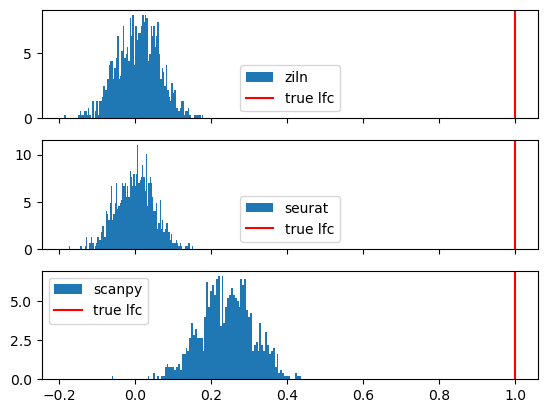

In [20]:
ziln_lfcs = get_ZILN_lfcs(np.exp(transform(X)) - 1, np.exp(transform(Y)) - 1, eps=1e-3)
suerat_lfcs = get_seurat_lfcs(X, Y, normalize=True)
scanpy_lfcs = get_scanpy_lfcs(X, Y, normalize=True)

_, axs = plt.subplots(3, 1, sharex=True)
for ax, (lfcs, name) in zip(axs, [(ziln_lfcs, "ziln"), (suerat_lfcs, "seurat"), (scanpy_lfcs, 'scanpy')]):
    ax.hist(lfcs.flatten(), bins=100, density=True, label=name)
    ax.axvline(true_lfc, 0, 1, color='red', label='true lfc')
    ax.legend()
plt.show()

The difference in log-means (i.e. the LFCs) of the normalized data sets **is** zero, so it's peculiar that scanpy finds a signal in this setting! Scanpy only finds an LFC signal when there one of the distributions produces sparse count data (you can try decreasing for instance $r_y$ in the code snippet two cells up). 

As said, now we remove the normalization and observe the estimated LFCs.

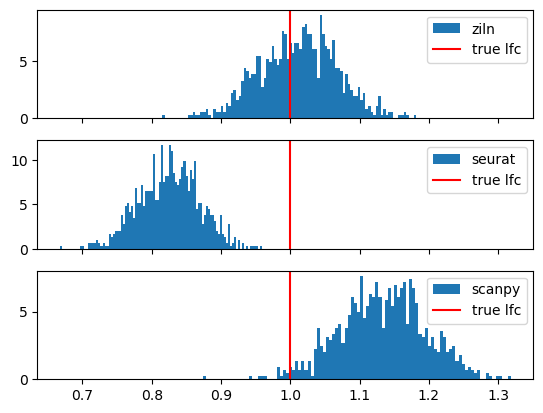

In [21]:
ziln_lfcs = get_ZILN_lfcs(X, Y, eps=1e-3)
suerat_lfcs = get_seurat_lfcs(X, Y, normalize=False)
scanpy_lfcs = get_scanpy_lfcs(X, Y, normalize=False)

_, axs = plt.subplots(3, 1, sharex=True)
for ax, (lfcs, name) in zip(axs, [(ziln_lfcs, "ziln"), (suerat_lfcs, "seurat"), (scanpy_lfcs, 'scanpy')]):
    ax.hist(lfcs.flatten(), bins=100, density=True, label=name)
    ax.axvline(true_lfc, 0, 1, color='red', label='true lfc')
    ax.legend()
plt.show()